# Toy Example - Hurricane Walaka

The first step is to play with a convenient, toy example!

### Preprocess Track Data

Well the actual first step is to import packages and get data. Since `ahlive` comes with tropical tutorial data, I will simply use that because it's convenient :).

In [1]:
import os
import xarray as xr
import pandas as pd
import ahlive as ah

df = ah.tutorial.open_dataset('tc_tracks')

TC TRACKS | Source: IBTrACS v04 - USA | https://www.ncdc.noaa.gov/ibtracs/


<ipython-input-1-223ae4867fd1>:6: DtypeWarning: Columns (8,9,23,24,25) have mixed types.Specify dtype option on import or set low_memory=False.
  df = ah.tutorial.open_dataset('tc_tracks')


I will further process the dataset:
    
1. select East Pacific TCs
2. resample the data to daily temporal resolution
3. rename column to time
4. shift longitudes from -180 to 180

In [2]:
df = df.loc[df['basin'] == 'EP']
df = df.groupby('name').resample('1D').mean().reset_index()
df = df.rename(columns={'iso_time': 'time'})
df.loc[df['lon'] < 0, 'lon'] += 360.

In this notebook, since I am just playing with a toy example, I will simply select one tropical cyclone: Walaka!

In [3]:
df_tc = df.loc[df['name'] == 'WALAKA'].copy()

### Preprocess SST Data

Then I will download some OISST data that correspond to Walaka's dates.

In [4]:
for time in df_tc['time']:
    _ = os.system(
        f'wget -nc https://www.ncei.noaa.gov/data/'
        f'sea-surface-temperature-optimum-interpolation/'
        f'v2.1/access/avhrr/{time:%Y%m}/'
        f'oisst-avhrr-v02r01.{time:%Y%m%d}.nc'
    )

Then read the gridded SST data!

In [5]:
ds = xr.open_mfdataset('oisst*.nc')[['sst']]

Since I am using my puny personal computer, to prevent it from going full-blown fan (overheating), I will coarsen the gridded dataset to every 1 degree.

In [6]:
ds = ds.coarsen(lat=4, lon=4).mean().squeeze().load()

/home/solactus/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


### Mimicking Paper's Methodology

Next, I wrote a function and a short snippet that reflects the methodology described in the paper (which happens to reference another paper):

"We employ a footprint method that samples storm properties within a 6 × 6 degree domain that is centered on the best track location and moves with each storm (as described in Li et al., 2016).

...

We characterize storm‐induced SST anomalies by following each storm track and subtracting the prestorm temperatures (−1 day relative to storm passage) from the poststorm temperatures (averaged from +3 to +5 days)."

In [7]:
def _sel_ds(ds, time, lat, lon):
    method = 'nearest' if not isinstance(time, slice) else None
    return ds.sel(
        time=time, method=method
    ).sel(
        lat=slice(lat - 3, lat + 3),
        lon=slice(lon - 3, lon + 3),
    ).load()

ds_list = []
for i, (r, row) in enumerate(df_tc.iterrows()):
    time_post = slice(
        row['time'] + pd.Timedelta('3D'),
        row['time'] + pd.Timedelta('5D')
    )
    time_past = row['time'] - pd.Timedelta('1D')
    ds_post = _sel_ds(ds, time_post, row['lat'], row['lon']).mean('time')
    ds_past = _sel_ds(ds, time_past, row['lat'], row['lon'])
    ds_anom = ds_post - ds_past
    ds_anom = ds_anom.reindex_like(ds).fillna(0)
    if i == 0:
        ds_list.append(ds_anom)
    else:
        ds_list.append(ds_list[-1] + ds_anom)

ds_footprint = xr.concat(
    ds_list, 'time'
).assign_coords(**{
    'time': df_tc['time'].values
})

### Animating TC Footprint

Just to validate that I did everything right (and also to test `ahlive`), I scale the radius of maximum winds (RMW) by some arbitrary factor and animate the TC footprint!

[########################################] | 100% Completed | 32.8s



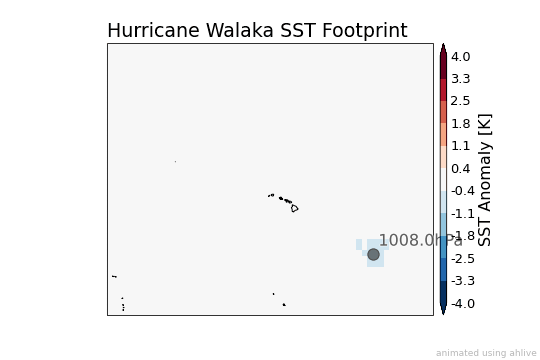

In [8]:
df_tc['scale'] = df_tc['usa_rmw'] ** 1.25

ah_df = ah.DataFrame(
    df_tc, 'lon', 'lat', s='scale', color='black', inline_labels='usa_pres',
    alpha=0.5, vmin=-4, vmax=4, coastline=True, xlims=(170, 230),
    ylims=(0, 50), cmap='RdBu_r', preset='trail', crs='PlateCarree',
    title='Hurricane Walaka SST Footprint', clabel='SST Anomaly [K]'
).config('preset', chart='both').config('inline', suffix='hPa')
ah_ds = ah.Dataset(ds_footprint, 'lon', 'lat', 'sst')

(ah_df * ah_ds).render()